# Identificació d'idiomes
Max Villalba i Biel Sánchez  
_Processament del Llenguatge Humà - GIA_  
___

# Introducció

En aquest treball desenvoluparem un model de predicció d’idioma basat en **Naive Bayes**, fent servir **trigrames** i aplicant **smoothing**, concretament el mètode de **Lidstone**.

Primer realitzarem un procés de **preprocessament** dels textos per preparar-los per al model. A continuació, entrenarem un model per a cada idioma utilitzant una part del conjunt de dades d’entrenament. Amb l’altra part del conjunt d’entrenament explorarem el paràmetre **lambda** per trobar el valor més adequat i, finalment, avaluarem el model amb el conjunt de proves per obtenir les mètriques de rendiment.

El nostre identificador de text serà capaç de distingir entre **anglès, alemany, francès, neerlandès, espanyol i italià**. Cada model es construirà específicament per a un idioma, i per fer la predicció assignarem a cada text l’idioma amb **la probabilitat més alta**.

A continuació, presentarem les funcions utilitzades per al model, detallarem l’entrenament dels models i descriurem la fase de test, amb un **anàlisi dels resultats i dels errors més significatius**.

# Funcions utilitzades

A continuació presentem les funcions que hem fet servir al llarg de tot el treball. Les hem agrupat aquí per tal de fer el codi més llegible i ordenat.

### Preprocessat

Aquesta funció s'encarrega del preprocessament del text. Tal com es descriu en els comentaris del codi, s'apliquen totes les transformacions requerides a la pràctica: eliminació de dígits, conversió a minúscules i normalització d'espais. A més, s'afegeix un doble espai al principi i al final del text per garantir la coherència en la generació de trigrames.

### Trigrames

Aquesta funció obté els **trigrames** d'un text i aplica un filtre que descarta aquells que apareixen menys de cinc vegades. La generació dels trigrames es fa amb la llibreria **NLTK** i retorna un diccionari amb la freqüència de cada trigram.

### Find Lambda

Definim un rang de valors de **lambda** que volem provar. Per a cada lambda, utilitzem el conjunt de **validació** (un subconjunt del train) per calcular la log-versemblança total de les frases. La lambda que maximitza aquesta log-versemblança és la que seleccionem per al model. La log-versemblança es calcula sumant les log-probabilitats de tots els trigrames i es normalitza per facilitar la comparació.

### Classificar

Un cop tenim els models entrenats i les lambdes definides, podem passar a la fase de test. Per a cada frase dels conjunts de test, calculem la probabilitat de pertinença a cada idioma i assignem com a predicció l'idioma del model que dóna la **major log-versemblança**. Tant en el test com en la validació, l'anàlisi es fa frase per frase, mentre que durant l'entrenament es passa tot el conjunt de trigrames de manera conjunta.

In [15]:
import re
import math
from nltk.collocations import TrigramCollocationFinder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

def preprocess_lines(text):
    """
    Processa el text línia per línia:
    - Elimina dígits
    - Posa en minúscules
    - Normalitza espais
    - Uneix totes les línies amb doble espai
    - Afegeix doble espai al principi i final
    """
    processed_lines = []

    for line in text.splitlines():
        line = re.sub(r"\d", "", line)

        line = line.lower()
        
        line = re.sub(r"\s+", " ", line).strip()
        
        if line: 
            processed_lines.append(line)
    
    result = "  ".join(processed_lines)
    
    result = "  " + result + "  "
    
    return result

def get_trigrams(text):
    finder = TrigramCollocationFinder.from_words(text)
    finder.apply_freq_filter(5)
    return finder.ngram_fd  # Retorna el diccionari de freqüències

def find_lambda(l, N, B, trigrams_trn, val_lines):
    best_lambda = None
    max_log_likelihood = -float('inf')

    for lam in l:
        total_log_likelihood = 0
        
        # Denominador de Lidstone: N + lambda * B 
        denominator = N + (lam * B)
        
        for line in val_lines:
            log_prob_doc = 0

            finder_val = TrigramCollocationFinder.from_words(line)
            
            # Iterem pels trigrames de la línia i les seves freqüències en aquesta línia
            for tg, freq_en_linia in finder_val.ngram_fd.items():
                # count: vegades que el trigrama de validació apareix al train
                count_trn = trigrams_trn.get(tg, 0)
                
                # Probabilitat de Lidstone 
                prob = (count_trn + lam) / denominator
                
                # Log-probabilitat acumulada: log P(d) = sum(log P(ei)) 
                # Multipliquem pel recompte del trigrama a la línia actual
                log_prob_doc += freq_en_linia * math.log(prob)
            
            total_log_likelihood += log_prob_doc
        
        avg_log_ll = total_log_likelihood / len(val_lines)
        print(f"Lambda: {lam:.1f} -> Log-Likelihood: {avg_log_ll:.4f}")
        
        if avg_log_ll > max_log_likelihood:
            max_log_likelihood = avg_log_ll
            best_lambda = lam

    print(f"\n Millor lambda: {best_lambda} (Score: {max_log_likelihood:.4f})")
    return best_lambda

def classify_sentence(sentence, models):
    """
    Classifica una frase donant-li el llenguatge amb més probabilitat
    models: dict amb {'spa': (trigrams, N, B, lambda), 'eng': ..., etc.}
    """
    best_lang = None
    max_log_prob = -float('inf')
    
    prepared_sentence = '  ' + sentence + '  '
    
    for lang, (trigrams, N, B, lambda_val) in models.items():
        log_prob = 0.0
        
        # Utilitzem TrigramCollocationFinder per extreure els trigrames
        finder = TrigramCollocationFinder.from_words(prepared_sentence)
        
        # Iterem pels trigrames i les seves freqüències
        for trigram, freq in finder.ngram_fd.items():
            c_T = trigrams.get(trigram, 0)
            prob = (c_T + lambda_val) / (N + lambda_val * B)
            log_prob += freq * math.log(prob)
        
        if log_prob > max_log_prob:
            max_log_prob = log_prob
            best_lang = lang
    
    return best_lang

# Train

El procediment d'entrenament és el mateix per a tots els idiomes, així que l'explicarem de manera general.

Primer llegim el fitxer corresponent a cada idioma i el preprocessem amb la funció que hem descrit anteriorment. A continuació, dividim el text per línies i separem els conjunts de **train** i **validació** (25k línies per a train i 5k per a validació).

El conjunt de train es torna a ajuntar en un únic text complet, ja que necessitem tota la informació per generar els trigrames, mentre que el conjunt de validació es manté separat per línies. Tot i així, a cada línia de validació s'afegeix un doble espai al principi i al final per conservar la coherència amb el train.

Seguidament, definim el rang de valors de **lambda** que volem explorar, així com els paràmetres **N** (nombre total de trigrames al train) i **B** (nombre de trigrames diferents al train). Amb aquests paràmetres, cridem la funció `find_lambda` per determinar la millor lambda, que servirà per definir el model combinant la informació del conjunt de train i del de validació.

Podem observar que la lambda escollida per a tots els idiomes és **1**, cosa que indica que una petita correcció additiva és suficient per evitar problemes de zero-probabilitat sense necessitat d’un suavitzat més gran.

### Castellà:

In [16]:
input_file = "langId/spa_trn.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

processed_text_spa = preprocess_lines(text)

lines = [line for line in processed_text_spa.split('  ') if line]

# Split 25K train, 5K val
train_lines = lines[:25000]
val_lines = ['  ' + line + '  ' for line in lines[25000:30000]]

train_text = '  ' + '  '.join(train_lines)

trigrams_spa = get_trigrams(train_text)

l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
N_spa = sum(trigrams_spa.values())
B_spa = len(trigrams_spa)

best_lambda_spa = find_lambda(l, N_spa, B_spa, trigrams_spa, val_lines)

Lambda: 0.1 -> Log-Likelihood: -948.5229
Lambda: 0.2 -> Log-Likelihood: -947.9692
Lambda: 0.3 -> Log-Likelihood: -947.6458
Lambda: 0.4 -> Log-Likelihood: -947.4168
Lambda: 0.5 -> Log-Likelihood: -947.2396
Lambda: 0.6 -> Log-Likelihood: -947.0952
Lambda: 0.7 -> Log-Likelihood: -946.9735
Lambda: 0.8 -> Log-Likelihood: -946.8685
Lambda: 0.9 -> Log-Likelihood: -946.7763
Lambda: 1.0 -> Log-Likelihood: -946.6941

 Millor lambda: 1 (Score: -946.6941)


### Anglès:

In [17]:
input_file = "langId/eng_trn.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

processed_text_eng = preprocess_lines(text)

lines = [line for line in processed_text_eng.split('  ') if line]

# Split 25K train, 5K val
train_lines = lines[:25000]
val_lines = ['  ' + line + '  ' for line in lines[25000:30000]]

train_text = '  ' + '  '.join(train_lines)

trigrams_eng = get_trigrams(train_text)

l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
N_eng = sum(trigrams_eng.values())
B_eng = len(trigrams_eng)

best_lambda_eng = find_lambda(l, N_eng, B_eng, trigrams_eng, val_lines)

Lambda: 0.1 -> Log-Likelihood: -872.6704
Lambda: 0.2 -> Log-Likelihood: -871.9110
Lambda: 0.3 -> Log-Likelihood: -871.4679
Lambda: 0.4 -> Log-Likelihood: -871.1543
Lambda: 0.5 -> Log-Likelihood: -870.9117
Lambda: 0.6 -> Log-Likelihood: -870.7142
Lambda: 0.7 -> Log-Likelihood: -870.5477
Lambda: 0.8 -> Log-Likelihood: -870.4040
Lambda: 0.9 -> Log-Likelihood: -870.2778
Lambda: 1.0 -> Log-Likelihood: -870.1653

 Millor lambda: 1 (Score: -870.1653)


### Francès:

In [18]:
input_file = "langId/fra_trn.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

processed_text_fra = preprocess_lines(text)

lines = [line for line in processed_text_fra.split('  ') if line]

# Split 25K train, 5K val
train_lines = lines[:25000]
val_lines = ['  ' + line + '  ' for line in lines[25000:30000]]

train_text = '  ' + '  '.join(train_lines)

trigrams_fra = get_trigrams(train_text)

l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
N_fra = sum(trigrams_fra.values())
B_fra = len(trigrams_fra)

best_lambda_fra = find_lambda(l, N_fra, B_fra, trigrams_fra, val_lines)

Lambda: 0.1 -> Log-Likelihood: -905.0553
Lambda: 0.2 -> Log-Likelihood: -904.5047
Lambda: 0.3 -> Log-Likelihood: -904.1831
Lambda: 0.4 -> Log-Likelihood: -903.9554
Lambda: 0.5 -> Log-Likelihood: -903.7792
Lambda: 0.6 -> Log-Likelihood: -903.6357
Lambda: 0.7 -> Log-Likelihood: -903.5147
Lambda: 0.8 -> Log-Likelihood: -903.4103
Lambda: 0.9 -> Log-Likelihood: -903.3187
Lambda: 1.0 -> Log-Likelihood: -903.2370

 Millor lambda: 1 (Score: -903.2370)


### Italià:

In [19]:
input_file = "langId/ita_trn.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

processed_text_ita = preprocess_lines(text)

lines = [line for line in processed_text_ita.split('  ') if line]

# Split 25K train, 5K val
train_lines = lines[:25000]
val_lines = ['  ' + line + '  ' for line in lines[25000:30000]]

train_text = '  ' + '  '.join(train_lines)

trigrams_ita = get_trigrams(train_text)

l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
N_ita = sum(trigrams_ita.values())
B_ita = len(trigrams_ita)

best_lambda_ita = find_lambda(l, N_ita, B_ita, trigrams_ita, val_lines)

Lambda: 0.1 -> Log-Likelihood: -928.5246
Lambda: 0.2 -> Log-Likelihood: -928.0253
Lambda: 0.3 -> Log-Likelihood: -927.7339
Lambda: 0.4 -> Log-Likelihood: -927.5277
Lambda: 0.5 -> Log-Likelihood: -927.3682
Lambda: 0.6 -> Log-Likelihood: -927.2384
Lambda: 0.7 -> Log-Likelihood: -927.1290
Lambda: 0.8 -> Log-Likelihood: -927.0347
Lambda: 0.9 -> Log-Likelihood: -926.9519
Lambda: 1.0 -> Log-Likelihood: -926.8782

 Millor lambda: 1 (Score: -926.8782)


### Alemany:

In [20]:
input_file = "langId/deu_trn.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

processed_text_deu = preprocess_lines(text)

lines = [line for line in processed_text_deu.split('  ') if line]

# Split 25K train, 5K val
train_lines = lines[:25000]
val_lines = ['  ' + line + '  ' for line in lines[25000:30000]]

train_text = '  ' + '  '.join(train_lines)

trigrams_deu = get_trigrams(train_text)

l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
N_deu = sum(trigrams_deu.values())
B_deu = len(trigrams_deu)

best_lambda_deu = find_lambda(l, N_deu, B_deu, trigrams_deu, val_lines)

Lambda: 0.1 -> Log-Likelihood: -862.3159
Lambda: 0.2 -> Log-Likelihood: -861.1327
Lambda: 0.3 -> Log-Likelihood: -860.4413
Lambda: 0.4 -> Log-Likelihood: -859.9515
Lambda: 0.5 -> Log-Likelihood: -859.5722
Lambda: 0.6 -> Log-Likelihood: -859.2629
Lambda: 0.7 -> Log-Likelihood: -859.0019
Lambda: 0.8 -> Log-Likelihood: -858.7764
Lambda: 0.9 -> Log-Likelihood: -858.5779
Lambda: 1.0 -> Log-Likelihood: -858.4009

 Millor lambda: 1 (Score: -858.4009)


### Neerlandès:

In [21]:
input_file = "langId/nld_trn.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

processed_text_nld = preprocess_lines(text)

lines = [line for line in processed_text_nld.split('  ') if line]

# Split 25K train, 5K val
train_lines = lines[:25000]
val_lines = ['  ' + line + '  ' for line in lines[25000:30000]]

train_text = '  ' + '  '.join(train_lines)

trigrams_nld = get_trigrams(train_text)

l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
N_nld = sum(trigrams_nld.values())
B_nld = len(trigrams_nld)

best_lambda_nld = find_lambda(l, N_nld, B_nld, trigrams_nld, val_lines)

Lambda: 0.1 -> Log-Likelihood: -815.3619
Lambda: 0.2 -> Log-Likelihood: -814.0927
Lambda: 0.3 -> Log-Likelihood: -813.3506
Lambda: 0.4 -> Log-Likelihood: -812.8244
Lambda: 0.5 -> Log-Likelihood: -812.4167
Lambda: 0.6 -> Log-Likelihood: -812.0840
Lambda: 0.7 -> Log-Likelihood: -811.8030
Lambda: 0.8 -> Log-Likelihood: -811.5600
Lambda: 0.9 -> Log-Likelihood: -811.3460
Lambda: 1.0 -> Log-Likelihood: -811.1549

 Millor lambda: 1 (Score: -811.1549)


# Test

Un cop trobada la millor **lambda** per cada idioma, passem a la fase de test.

En aquesta part, utilitzarem diferents fitxers de prova escrits en diferents llengues per obtenir les **mètriques de rendiment** i veure que tant adequat és el model que hem construït.

En primer lloc, descobrirem que tant bé identifica les llengues el nostre model. Definim un diccionari `models` on, per cada idioma, indiquem els **trigrames**, la **N** i la **B** (obtenides a partir del conjunt de train), i la **millor lambda** (obtenida a partir del conjunt de validació).

Seguidament, definim els fitxers que llegirem i tres contenidors: `results` per guardar el total de frases classificades correctament, `confusion_matrix` per obtenir on s'han classificat les diferents frases (per més endavant construïr la matriu de confusió) i `errors` per guardar les frases mal classificades, així com la seva longitud i a quin idioma haurien de pertànyer (per finalment fer l'anàlisi dels errors).

Recordem que, tal i com hem indicat a l'apartat de les funcions utilitzades, assignarem com a predicció l'idioma que dona la **major log-versemblança**.

Finalment, calculem l'**acccuracy global** per veure quantes frases s'han classificat correctament a nivell general.

Podem observar que el model que hem contruït classifica de manera correcta la gran majoria de frases del fitxers de prova. L'idioma que pitjor es detecta és el **neerlandés**, tot i que la diferència és **mínima** en comparació a les altres llengues. A nivell global podem veure que l'accuracy també presenta un valor **molt elevat**, indicant que el model ha aconseguit identificar bé la gran majoria de casos.

In [22]:
models = {
    'spa': (trigrams_spa, N_spa, B_spa, best_lambda_spa),
    'eng': (trigrams_eng, N_eng, B_eng, best_lambda_eng),
    'fra': (trigrams_fra, N_fra, B_fra, best_lambda_fra),
    'ita': (trigrams_ita, N_ita, B_ita, best_lambda_ita),
    'deu': (trigrams_deu, N_deu, B_deu, best_lambda_deu),
    'nld': (trigrams_nld, N_nld, B_nld, best_lambda_nld)
}

test_files = ['spa_tst.txt', 'eng_tst.txt', 'fra_tst.txt', 'ita_tst.txt', 'deu_tst.txt', 'nld_tst.txt']
langs = list(models.keys())

# Contenidors per guardar els resultats
results = {}
confusion_matrix = {true_l: {pred_l: 0 for pred_l in langs} for true_l in langs}
errors = []

for test_file in test_files:
    true_lang = test_file.split('_')[0]
    
    with open(f'langId/{test_file}', 'r', encoding='utf-8') as f:
        test_text = f.read()
    
    processed_test = preprocess_lines(test_text)
    test_sentences = [line for line in processed_test.split('  ') if line]
    
    correct = 0
    for sentence in test_sentences:
        pred_lang = classify_sentence(sentence, models)
        confusion_matrix[true_lang][pred_lang] += 1
        
        if pred_lang == true_lang:
            correct += 1
        else:
            errors.append({'sentence': sentence, 'length': len(sentence), 'true': true_lang, 'pred': pred_lang})
    
    results[true_lang] = {'total': len(test_sentences), 'correct': correct}
    print(f"{true_lang.upper()}: {correct}/{len(test_sentences)} ({100*correct/len(test_sentences):.2f}%)")

# Accuracy global
total_correct = sum(r['correct'] for r in results.values())
total_sentences = sum(r['total'] for r in results.values())
print(f"\n Accuracy Global: {total_correct}/{total_sentences} ({100*total_correct/total_sentences:.2f}%)")

SPA: 9992/10000 (99.92%)
ENG: 9983/9987 (99.96%)
FRA: 9995/10005 (99.90%)
ITA: 9984/10003 (99.81%)
DEU: 9980/9990 (99.90%)
NLD: 9977/10000 (99.77%)

 Accuracy Global: 59911/59985 (99.88%)


Un cop aconseguits els resultats, ara veurem la **matriu de confusió**, la qual construirem a partir del contenidor `confusion_matrix`.

Tal i com hem comentat a l'apartat anterior, el model aconsegueix identificar de manera **gairebé perfecta** totes les frases, amb alguna excepció puntual (que ja comentarem a l'apartat de l'anàlisi dels errors). Això ho podem observar veient que pràcticament tots els valors es concentren en la **diagonal** de la matriu.

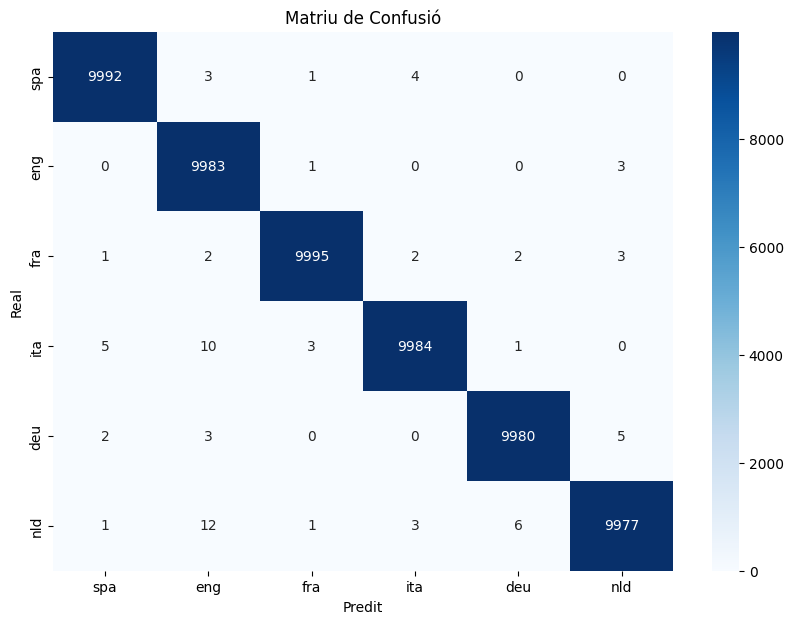

In [23]:
df_cm = pd.DataFrame.from_dict(confusion_matrix, orient='index')[langs]

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriu de Confusió')
plt.xlabel('Predit')
plt.ylabel('Real')
plt.show()

Per acabar, passem a l'**anàlisi dels errors**.

En aquest apartat comprovarem quines característiques tenen els errors que el model no ha sigut capaç de classificar correctament.

Primer, comptarem **quants errors** tenim i quina és la seva **longitud mitjana**. A continuació, investigarem la quantitat d'errors produïts en funció de la **longitud** de la frase i, finalment, descobrirem quines han sigut les **confusions més freqüents**, indicant alguns exemples també en funció de la longitud de la frase.

In [24]:
avg_len = sum(e['length'] for e in errors) / len(errors) if errors else 0
print(f"Total errors: {len(errors)}")
print(f"Longitud mitjana: {avg_len:.1f} caràcters")

short = sum(1 for e in errors if e['length'] < 70)
medium = sum(1 for e in errors if 70 <= e['length'] < 150)
long = sum(1 for e in errors if e['length'] >= 150)
print(f"\nPer longitud:")
print(f"   - Curtes (<70 caràcters): {short} ({100*short/len(errors):.1f}%)")
print(f"   - Mitjanes (70-150 caràcters): {medium} ({100*medium/len(errors):.1f}%)")
print(f"   - Llargues (>150 caràcters): {long} ({100*long/len(errors):.1f}%)")

confusions = Counter((e['true'], e['pred']) for e in errors)
print(f"\nConfusions més freqüents (real → predit):")
for (true_l, pred_l), count in confusions.most_common(10):
    print(f"   {true_l} → {pred_l}: {count}")

print(f"\nExemples d'errors curts (real → predit):")
for e in [e for e in errors if e['length'] < 70][:5]:
    print(f"   '{e['sentence']}' | {e['true']} → {e['pred']}")

print(f"\nExemples d'errors mitjans (real → predit):")
for e in [e for e in errors if 70 <= e['length'] < 150][:5]:
    print(f"   '{e['sentence']}' | {e['true']} → {e['pred']}")

print(f"\nExemples d'errors llargs (real → predit):")
for e in [e for e in errors if e['length'] >= 150][:5]:
    print(f"   '{e['sentence']}' | {e['true']} → {e['pred']}")

Total errors: 74
Longitud mitjana: 62.7 caràcters

Per longitud:
   - Curtes (<70 caràcters): 50 (67.6%)
   - Mitjanes (70-150 caràcters): 20 (27.0%)
   - Llargues (>150 caràcters): 4 (5.4%)

Confusions més freqüents (real → predit):
   nld → eng: 12
   ita → eng: 10
   nld → deu: 6
   ita → spa: 5
   deu → nld: 5
   spa → ita: 4
   spa → eng: 3
   eng → nld: 3
   fra → nld: 3
   ita → fra: 3

Exemples d'errors curts (real → predit):
   'torre de control responde negativamente.' | spa → ita
   'del beagle no he escrito nada.' | spa → ita
   'se me puso la carne de gallina.' | spa → ita
   'all nippon airways recibe el primer boeing dreamliner tokio (efe).' | spa → eng
   'explique brevemente por qué.' | spa → fra

Exemples d'errors mitjans (real → predit):
   'amy winehouse, su vida en imágenes fotos - shaun curry (afp) - -- muere amy winehouse.' | spa → eng
   'philip smith says: december th, at : pm hola, soy productor habitual de cerveza artesanal.' | spa → eng
   'actueilement, il 

Podem observar que tenim un total de **74 errors**, els quals la majoria són de **frases curtes**, amb una longitud mitjana d'uns **63 caràcters** aproximadament. Els errors a **frases mitjanes** i **llargues** són menys frequents, fet que podria indicar que com més llarg és un text, més facilitat té el model d'identificar l'idioma correctament.

En quant a les **confusions més frequents**, podem veure que la més comuna és que el **neerlandés és confon amb l'anglès**, el qual té sentit ja que són dues llengues similars en molts aspectes. Tot i així, es sorprenent veure com **l'italià també es confon bastant amb l'anglès**, ja que aquestes dues llengues són força diferents.

Si mirem diversos exemples, podem veure que la majoria de confusions als **exemples curts** provenen de que el castellà es confon amb l'italià, fet que té sentit ja que, amb poc context, les dues llengues són molt similars. Aquesta característica desapareix quan observem els **exemples mitjans i llargs**, on podem descobrir que moltes vegades (i amb idiomes molt diferents) **es prediu com a anglès**.

Observant els resultats podem veure que moltes confusions es produeixen degut a l'**existència de paraules d'un idioma** en una frase d'un idioma diferent. Es per això que l'anglès es prediu tantes vegades, ja que és una llengua força present en diversos documents.

# Conclusió

En aquest treball hem desenvolupat un model que identifica diversos textos en diferents idiomes i intenta classificar-los correctament en funció de la llengua predita.

Hem començat fent un **preprocessat** seguint les indicacions de l'enunciat: eliminar dígits, convertir a minúscula i normalitzar espais.

Seguidament, i per cada fitxer d'entrenament, hem dividit el conjunt en **train** i **validació**, els quals hem utilitzat per trobar els **trigrames**, la **N** i la **B** (en el cas del conjunt train) i la **lambda** adequada (a partir del conjunt de validació), utilitzant com a tècnica d'_smoothing_ el mètode de **Lidstone**.

Un cop trobada la millor lambda per cada llengua hem passat a la fase de **test**, on el model construït ha intentat predir la llengua de les diferents frases dels fitxers de test. El model ha aconseguit predir de manera més que satisfactoria la majoria de frases, tal i com s'observa en la **matriu de confusió**, fallant en aquelles on les llengues són **molt semblants** (com l'italià i el castellà) o en aquells casos on hi ha la presència d'un **altre idioma** en un frase d'un idioma concret (com és el cas de l'anglès).